# Regularization

In general, we aim to choose parameters $\theta$ such that the empirical risk $\mathcal{L}(\theta)$ is small.  
However, we also want to avoid overfitting the model $g(\theta)$.  
A **regularizer**  
$$
\mathcal{R}: \mathbb{R}^{p} \rightarrow \mathbb{R}
$$
is a function that penalizes model complexity or sensitivity.

In **regularized empirical risk minimization (RERM)**, we choose $\theta$ to minimize
$$
\mathcal{L}(\theta) + \lambda \mathcal{R}(\theta),
$$
where $\lambda > 0$ is a hyperparameter controlling the amount of regularization.  
We typically select $\lambda$ to minimize the test error.

More generally, regularization takes the form
$$
\mathcal{L}(\theta) + \lambda \mathcal{R}(\theta), \quad \lambda > 0.
$$

When using the squared (quadratic) loss  
$$
l(\hat{y}, y) = (\hat{y} - y)^2
$$  
together with regularization, minimizing the following expressions gives:

- **Ridge regression:**  
  $$
  \mathcal{L}(\theta) + \lambda \lVert \theta \rVert_2^2
  $$

- **Lasso regression:**  
  $$
  \mathcal{L}(\theta) + \lambda \lVert \theta \rVert_1
  $$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

Several parts of this lab were kindly borrowed from the  
[SDS 293 Machine Learning course, Lab 10](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html).

In this dataset, we will predict players' salaries based on their game statistics.  
Before proceeding, let's load the data and ensure that any missing values have been removed.


In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv',
                 index_col=0).dropna()

Next, we one-hot encode the `League`, `Division`, and `NewLeague` columns using `pandas`.

In [3]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])


# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    bool   
 17  Division_W   263 non-null    bool   
 18  NewLeague_N  263 non-null    bool 

Here, we extract the response variable into `y`.  
If you want, you can also inspect its distribution by plotting a histogram.

In [4]:
y = df.Salary

To prepare the data for regularized regression methods, we first scale the features by dividing them by their standard deviation.


In [5]:
scaler = StandardScaler(with_mean=False)
X_s = scaler.fit_transform(X)

## Ridge Regression
Ridge regression uses the squared $L_2$ norm to regularize the coefficients, which reduces the variance of the model and helps prevent overfitting.

The `Ridge()` constructor includes an `alpha` parameter (equivalent to $\lambda$, just under a different name!) that controls the amount of regularization.  
We will generate an array of alpha values ranging from very large to very small, effectively covering the full spectrum of models—from the null model containing only the intercept to the ordinary least squa


In [6]:
alphas = 10**np.linspace(10,-2,100)*0.5
# or alternatively
alphas = np.logspace(10, -2, 100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Each value of `alpha` corresponds to a vector of ridge regression coefficients, and we will store all of these vectors in a matrix `coefs`.  
In this example, `coefs` will be a $19 \times 100$ matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of `alpha`).

Remember that we should standardize the variables so they are on the same scale.  
To do this automatically within the model, we can use the parameter `normalize=True`:


In [7]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_s, y)
    coefs.append(ridge.coef_)

np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller—in terms of their $L_2$ norm—when a large value of `alpha` is used, compared to when a small value is used.  
Let's plot the coefficient paths and observe how the values of the coefficients change relative to the `alpha` parameter:

Text(0, 0.5, 'weights')

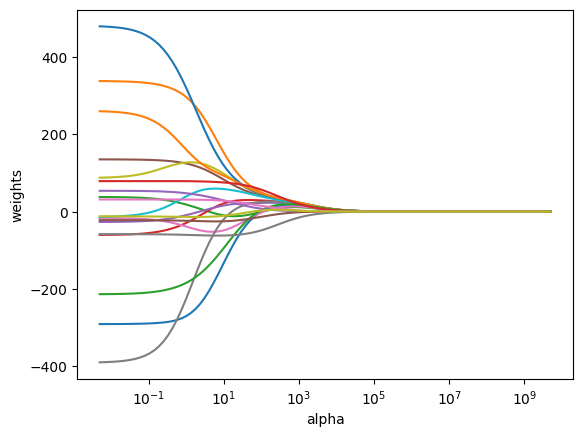

In [8]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso.

In [9]:
# Splits data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=1)

Next, we fit a ridge regression model on the training set and evaluate its MSE on the test set, using $\lambda = 4$:

In [10]:
ridge_a4 = Ridge(alpha = 4)
ridge_a4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred_a4 = ridge_a4.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge_a4.coef_, index = X.columns)) # Print coefficients
print(f"Intercept:{ridge_a4.intercept_}")
print(f"MSE estimate using ridge with alpha=4: {mean_squared_error(y_test, pred_a4):.3f}")
print(f"Penalty for lambda = 4: {sum(ridge_a4.coef_**2)}")

AtBat         -207.131515
Hits           218.005652
HmRun          -25.328318
Runs            19.315670
RBI             25.889736
Walks           83.644763
Years          -35.750522
CAtBat        -114.314911
CHits          120.240614
CHmRun          94.114487
CRuns          142.515702
CRBI            94.378595
CWalks        -104.407784
PutOuts         82.661428
Assists         -0.172325
Errors           9.992229
League_N        18.764448
Division_W     -59.410217
NewLeague_N      3.100289
dtype: float64
Intercept:124.57770785408604
MSE estimate using ridge with alpha=4: 126386.135
Penalty for lambda = 4: 187715.71909347843


The test MSE when `alpha = 4` is $126386$.  
Now let's see what happens if we use a very large value of `alpha`, such as $10^{10}$.

---

**Your task:**  
---

Create a ridge regression model with a huge value of `alpha` (e.g., $10^{10}$).  
Fit the model to the training data and use it to generate predictions on the test set.


In [11]:
ridge_a10 = Ridge(alpha = 10**10)
ridge_a10.fit(X_train, y_train)
pred_a10 = ridge_a10.predict(X_test)
print(pd.Series(ridge_a10.coef_, index = X.columns))
print(f"MSE of estimate using ridge with alpha=10^10: {mean_squared_error(y_test, pred_a10):.3f}")

AtBat          3.786987e-06
Hits           4.221384e-06
HmRun          3.260094e-06
Runs           4.079701e-06
RBI            4.407323e-06
Walks          4.282162e-06
Years          3.553376e-06
CAtBat         4.774574e-06
CHits          5.046633e-06
CHmRun         5.038011e-06
CRuns          5.169575e-06
CRBI           5.327092e-06
CWalks         4.534876e-06
PutOuts        3.538987e-06
Assists       -6.491208e-08
Errors         2.058551e-07
League_N      -2.645545e-07
Division_W    -1.819724e-06
NewLeague_N   -1.806981e-07
dtype: float64
MSE of estimate using ridge with alpha=10^10: 229163.238


Okay, so fitting a ridge regression model with `alpha=4` leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with `alpha=4` instead of
just performing least squares regression. Recall that least squares is simply ridge regression with `alpha=0`.

In [12]:
ridge_ols = Ridge(alpha=0)
ridge_ols.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge_ols.predict(X_test)            # Use this model to predict the test data
print("Coefficients:")
print(pd.Series(ridge_ols.coef_, index = X.columns)) # Print coefficients
print(f"MSE of OLS estimate using ridge with alpha=0: {mean_squared_error(y_test, pred):.3f}")

Coefficients:
AtBat         -275.905642
Hits           296.788147
HmRun            2.225432
Runs           -11.362464
RBI              1.004830
Walks           98.907425
Years           29.407074
CAtBat        -813.318850
CHits          640.286903
CHmRun         130.472905
CRuns          253.150060
CRBI            86.295788
CWalks        -117.399498
PutOuts         80.226448
Assists         20.646370
Errors          10.912621
League_N        25.936375
Division_W     -58.277097
NewLeague_N     -1.625270
dtype: float64
MSE of OLS estimate using ridge with alpha=0: 133595.033


It looks like we are improving over regular least squares!

Instead of arbitrarily choosing $\alpha = 4$, it is better to use cross-validation to select the tuning parameter $\alpha$.  
We can do this using the cross-validated ridge regression function `RidgeCV()`.  
By default, the function performs generalized cross-validation, although this behavior can be changed using the `cv` argument.

Note that the attribute `alpha_` of `ridgecv` object contains the value of `alpha` selected by cross-validation.


In [15]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print(f"Best value of alpha parameter: {ridgecv.alpha_}")

Best value of alpha parameter: 2.320794416806386


Therefore, we see that the value of alpha that results in the smallest cross-validation error is $2.32$. What is the test MSE associated with this value of alpha?

Below, create a regression model with `alpha` parameter equal to the value of the alpha corresponding to the lowest MSE found in crossvalidation above.

Also, we check the sum of squares of the coefficients to see how the penalty term changed.

In [16]:
ridge_acv = Ridge(alpha = ridgecv.alpha_)
ridge_acv.fit(X_train, y_train)
print(f"MSE of Ridge: {mean_squared_error(y_test, ridge_acv.predict(X_test)):.0f}")
print(f"Penalty for lambda selected by cross-validation: {sum(ridge_acv.coef_**2)}")

MSE of Ridge: 126101
Penalty for lambda selected by cross-validation: 273451.23121865327


This represents a further improvement over the test MSE that we got using
$\lambda = 4$. Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [17]:
ridge_acv.fit(X_s, y)
pd.Series(ridge_acv.coef_, index = X.columns)

AtBat         -239.529736
Hits           257.401290
HmRun            7.236367
Runs           -10.230880
RBI              0.197507
Walks          114.023114
Years          -48.458499
CAtBat        -134.833826
CHits          125.140491
CHmRun          54.184164
CRuns          238.669097
CRBI           126.929378
CWalks        -161.147485
PutOuts         78.075376
Assists         42.349675
Errors         -24.702896
League_N        30.607456
Division_W     -61.287764
NewLeague_N    -13.826883
dtype: float64

As expected, none of the coefficients are exactly zero — ridge regression does not perform variable selection!

## The Lasso

We saw that ridge regression, with an appropriate choice of `alpha`, can outperform both least squares and the null model on the Hitters dataset.  
We now ask whether the **lasso** can produce a model that is either more accurate or more interpretable than ridge regression.

To fit a lasso model, we use the `Lasso()` function.  
This time, we need to specify the argument `max_iter = 10000` to ensure convergence.  
Other than that, we proceed in the same way as we did when fitting the ridge model:


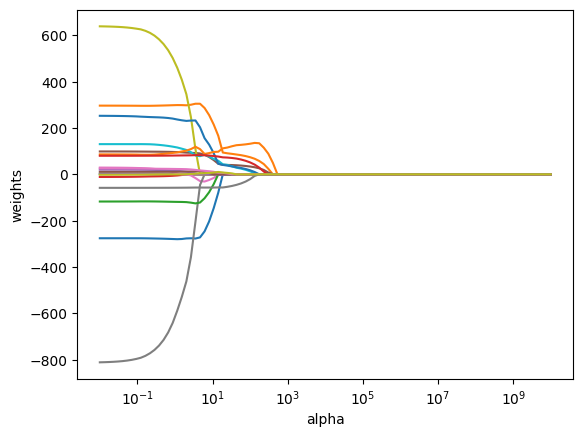

In [18]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
_=plt.ylabel('weights')

Notice in the coefficient plot that, depending on the choice of the tuning parameter, some of the coefficients become exactly zero.  
This is a key property of the lasso.

We now perform 10-fold cross-validation to choose the best value of `alpha`, refit the model using that value, and compute the corresponding test error:


In [19]:
lassocv = LassoCV(alphas = 100, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,100
,fit_intercept,True
,precompute,'auto'
,max_iter,100000
,tol,0.0001
,copy_X,True
,cv,10
,verbose,False
,n_jobs,None


After selecting the best value of `alpha`, we need to refit the model using this value. We do this by calling the `set_params` method and then fitting the model again on the training data.

Next, compute the mean squared error and the penalty term.


In [26]:
# set the parameter alpha to the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
# fit the lasso model
print(f"MSE of lasso with best alpha: {mean_squared_error(y_test, lassocv.predict(X_test)):.0f}")
# penalty value of lasso
print(f"Penalty for the given lasso: {sum(np.abs(lassocv.coef_))}")

MSE of lasso with best alpha: 124737
Penalty for the given lasso: 1205.1140503295187


This test MSE is substantially lower than that of both the null model and ordinary least squares, and only slightly worse than the test MSE of ridge regression with `alpha` chosen via cross-validation.

However, the lasso has a major advantage over ridge regression: the resulting coefficient estimates are **sparse**.  
In the plot below, notice that 13 of the 19 coefficient estimates are exactly zero.


In [27]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lassocv.coef_, index=X.columns)

AtBat         -233.724426
Hits           277.626165
HmRun           -0.000000
Runs             0.000000
RBI              0.000000
Walks           81.867897
Years          -29.068716
CAtBat          -0.000000
CHits            0.000000
CHmRun          82.509991
CRuns          148.155943
CRBI            89.234325
CWalks         -95.553248
PutOuts         81.991833
Assists          0.000000
Errors           8.495856
League_N        14.684604
Division_W     -57.072892
NewLeague_N      5.128154
dtype: float64

## Elastic Net

A method that combines both ridge and lasso penalties—i.e., using both $L_1$ and $L_2$ regularization—is called **elastic net** regression.  
It includes the regularization parameter $\lambda$, which controls the overall strength of the penalty, and the mixing parameter $\alpha$, which controls the proportion of $L_1$ vs. $L_2$ regularization:

$$
\mathcal{L}(\theta) + \lambda \bigl(\alpha \lVert \theta \rVert_1 + (1 - \alpha)\lVert \theta \rVert_2^2 \bigr),
\qquad \alpha \in \langle 0, 1 \rangle.
$$

- If $\alpha = 0.5$, the $L_1$ and $L_2$ penalties contribute equally.  
- If $\alpha = 0$, the method reduces to ridge regression.  
- If $\alpha = 1$, the method becomes lasso regression.


---

**Task**

---

Refer to the documentation for [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Using cross-validation together with grid search, try to find the best combination of the parameters:

- `alpha` (corresponding to $\lambda$), and  
- `l1_ratio` (corresponding to $\alpha$ in the elastic net formulation)

for the dataset used above.

You may ignore `ConvergenceWarning` m


In [24]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Print the train and test MSE of the estimator that corresponds to the lowest training error.

In [28]:
param_grid = {
    'alpha': alphas,
    'l1_ratio': np.linspace(0, 1, 20)
}

model = ElasticNet(max_iter=10000)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)


,estimator,ElasticNet(max_iter=10000)
,param_grid,"{'alpha': array([5.0000...00000000e-03]), 'l1_ratio': array([0. ..., 1. ])}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0....0179342179024)


Finally, print the coefficients corresponding to the best model.

In [33]:
best_param = grid.best_params_
print(best_param)
elastic = ElasticNet(**best_param)
elastic.fit(X_train, y_train)
print(f"MSE of ElasticNet with best alpha: {mean_squared_error(y_test, elastic.predict(X_test))}")
print(f"Penalty for the given ElasticNet: {sum(np.abs(elastic.coef_)*elastic.l1_ratio + np.sum(1 - elastic.l1_ratio)*elastic.coef_**2)}")


{'alpha': np.float64(0.14240179342179024), 'l1_ratio': np.float64(0.9473684210526315)}
MSE of ElasticNet with best alpha: 126093.8536968687
Penalty for the given ElasticNet: 19191.901412059
